In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from hlsstack.hls_funcs.smooth import despike_ts, double_savgol
from hlsstack.hls_funcs.masks import bolton_mask_np

In [4]:
df_ts = pd.read_csv('../data/raw_tmp/ts_raw_vor_plots.csv', parse_dates=[1])

In [5]:
df_ts

,Id,Date,NDVI,DFI,NDTI,SATVI,NDII7,BAI_126,BAI_136,BAI_146,...,BAI_146_smooth,BAI_236_smooth,BAI_246_smooth,BAI_346_smooth,BLUE_smooth,GREEN_smooth,RED_smooth,NIR1_smooth,SWIR1_smooth,SWIR2_smooth
0,10S_P1,2012-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,149.088016,158.740129,150.554419,149.115921,1024.228735,1349.873157,1623.778619,2333.400541,3853.511154,3229.198509
1,10S_P1,2012-11-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,149.088016,158.740129,150.554419,149.115921,1024.228735,1349.873157,1623.778619,2333.400541,3853.511154,3229.198509
2,10S_P1,2012-11-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,149.088016,158.740129,150.554419,149.115921,1024.228735,1349.873157,1623.778619,2333.400541,3853.511154,3229.198509
3,10S_P1,2012-11-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,149.088016,158.740129,150.554419,149.115921,1024.228735,1349.873157,1623.778619,2333.400541,3853.511154,3229.198509
4,10S_P1,2012-11-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,149.088016,158.740129,150.554419,149.115921,1024.228735,1349.873157,1623.778619,2333.400541,3853.511154,3229.198509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636167,CN_P4,2023-02-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,143.184366,145.367671,145.472739,148.226423,974.369199,1368.043323,1770.098839,2437.529402,3496.066987,3061.256326
636168,CN_P4,2023-02-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,143.034309,144.944777,145.213979,148.083184,963.323788,1354.883608,1762.753187,2432.819740,3496.314291,3054.570844
636169,CN_P4,2023-02-27,0.163246,9.623705,0.072161,0.104399,-0.111022,144.810566,143.179474,142.903004,...,142.874251,144.488899,144.933018,147.926043,951.662861,1340.796118,1754.942939,2427.934476,3497.071590,3047.594946
636170,CN_P4,2023-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,142.703830,143.998941,144.629010,147.754389,939.371751,1325.753074,1746.655821,2422.874277,3498.367095,3040.323352


<AxesSubplot:xlabel='Date', ylabel='SWIR2'>

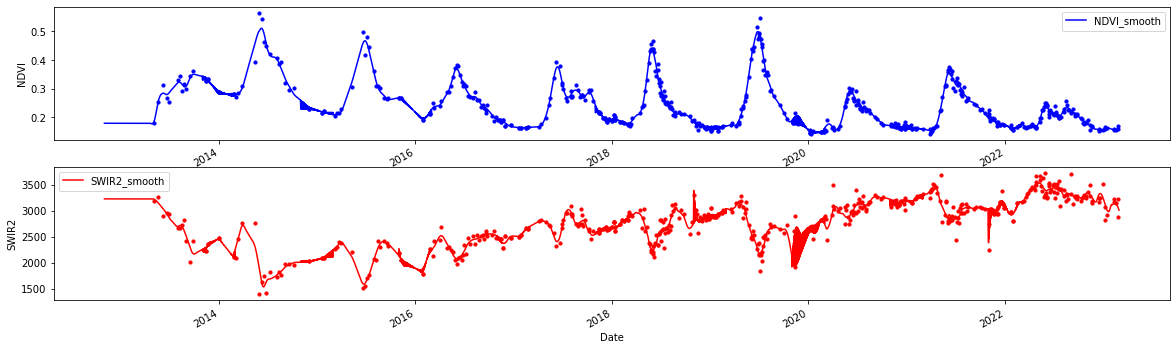

In [6]:
# plot updated smooth with start of season (blue) and peak of season (red)
plot = '10S_P1'
var1 = 'NDVI'
var2 = 'SWIR2'

fig, axs = plt.subplots(figsize=(20, 6), nrows=2)
df_ts[df_ts['Id'] == plot].plot.scatter(x='Date', y=var1, ax=axs[0], c='blue', s=10)
df_ts[df_ts['Id'] == plot].plot(x='Date', y= var1 + '_smooth', ax=axs[0], c='blue')

df_ts[df_ts['Id'] == plot].plot.scatter(x='Date', y=var2, ax=axs[1], c='red', s=10)
df_ts[df_ts['Id'] == plot].plot(x='Date', y= var2 + '_smooth', ax=axs[1], c='red')

In [7]:
df_ts = df_ts.drop_duplicates(subset=['Id', 'Date'], keep='last').copy()

In [8]:
def bolton_mask(blue, swir2):

    indices = blue.index

    ts_blue = blue.values
    ts_swir2 = swir2.values
    
    def cloud_outlier_mask(da_blue):
        blue_ts = da_blue / 10000.0
        cloud_mask = np.zeros_like(blue_ts)
        for idx in range(len(blue_ts)):
            if not np.isnan(blue_ts[idx]):
                idx_clear = np.where(~np.isnan(blue_ts))[0]
                if idx == np.min(idx_clear):
                    continue
                else:
                    idx_pre = np.max(idx_clear[idx_clear < idx])
                    blue_diff = blue_ts[idx] - blue_ts[idx_pre]
                    cloud_thresh = 0.03 * (1 + (idx - idx_pre) / 30)
                    if blue_diff > cloud_thresh:
                        blue_ts[idx] = np.nan
                        cloud_mask[idx] = 1
                    else:
                        continue
            else:
                continue
        return cloud_mask

    def shadow_outlier_mask(da_swir2):
        swir2_ts = da_swir2.copy()
        shadow_mask = np.zeros_like(swir2_ts)
        for idx in range(len(swir2_ts)):
            if not np.isnan(swir2_ts[idx]):
                idx_clear = np.where(~np.isnan(swir2_ts))[0]
                if idx == np.min(idx_clear):
                    continue
                elif idx == np.max(idx_clear):
                    try:
                        idx_pre = idx_clear[idx_clear < idx][-1]
                        idx_pre2 = idx_clear[idx_clear < idx][-2]
                        y = np.array([swir2_ts[idx_pre2], swir2_ts[idx_pre]])
                        x = np.array([idx_pre2, idx_pre])
                        dx = np.diff(x)
                        dy = np.diff(y)
                        slope = dy / dx
                        swir2_interp = swir2_ts[idx_pre] + slope[0] * (idx - idx_pre)
                        swir2_diff = swir2_interp - swir2_ts[idx]
                        if (swir2_ts[idx_pre] - swir2_ts[idx_pre2]) == 0:
                            shadow_val = np.nan
                        else:
                            shadow_val = swir2_diff / (swir2_ts[idx_pre] - swir2_ts[idx_pre2])
                        if (idx - idx_pre2 < 45) & (swir2_diff > 500) & (np.abs(shadow_val) > 2):
                            swir2_ts[idx] = np.nan
                            shadow_mask[idx] = 1
                        else:
                            continue
                    except IndexError:
                        continue
                else:
                    idx_pre = idx_clear[idx_clear < idx][-1]
                    idx_post = idx_clear[idx_clear > idx][0]
                    y = np.array([swir2_ts[idx_pre], swir2_ts[idx_post]])
                    x = np.array([idx_pre, idx_post])
                    dx = np.diff(x)
                    dy = np.diff(y)
                    slope = dy / dx
                    swir2_interp = swir2_ts[idx_pre] + slope[0] * (idx - idx_pre)
                    swir2_diff = swir2_interp - swir2_ts[idx]
                    if (swir2_ts[idx_post] - swir2_ts[idx_pre]) == 0:
                        shadow_val = np.nan
                    else:
                        shadow_val = swir2_diff / (swir2_ts[idx_post] - swir2_ts[idx_pre])
                    if (idx_post - idx_pre < 45) & (swir2_diff > 500) & (np.abs(shadow_val) > 2):
                        swir2_ts[idx] = np.nan
                        shadow_mask[idx] = 1
                    else:
                        continue
            else:
                continue
        return shadow_mask

    shadow_outliers = shadow_outlier_mask(ts_swir2)
    ts_blue[shadow_outliers == 1]= np.nan
    cloud_outliers = cloud_outlier_mask(ts_blue)
    mask = np.maximum(cloud_outliers, shadow_outliers)
    mask = pd.Series(mask, index=indices)
    return mask

In [9]:
def adapt_smooth(ts, dates, despike=True, dat_thresh=None):
    ct_valid = sum(~np.isnan(ts[(dates.dt.month >= 3) & (dates.dt.month <= 10)]))
    if 180 / ct_valid > 15:
        despike = False
    if despike:
        if dat_thresh is None:
            _dat_thresh = np.ptp(ts.values) * 0.10
        else:
            _dat_thresh = dat_thresh
        ts_ds = despike_ts(ts.values, dat_thresh=_dat_thresh, days_thresh=45)
    else:
        ts_ds = ts.values
    if 180 / ct_valid > 10:
        ts_smooth = double_savgol(ts_ds, double=True, window1_max=7, window2=31, limit=91)
    elif 180 / ct_valid > 7:
         ts_smooth = double_savgol(ts_ds, double=True, window1_max=5, window2=41, limit=91)
    elif 180 / ct_valid > 5:
         ts_smooth = double_savgol(ts_ds, double=True, window1_max=5, window2=51, limit=91)
    else:
        ts_smooth = double_savgol(ts_ds, double=False, window2=51, limit=91)
    return pd.Series(ts_smooth, ts.index.get_level_values(-1))

def set_smooth(ts, dates, despike=True, dat_thresh=None):
    if despike:
        if dat_thresh is None:
            _dat_thresh = np.ptp(ts.values[~np.isnan(ts.values)]) * 0.10
        else:
            _dat_thresh = dat_thresh
        ts_ds = despike_ts(ts.values, dat_thresh=_dat_thresh, days_thresh=45)
    ts_smooth = double_savgol(ts_ds, double=True, window1_max=9, window2=41, limit=91)
    return pd.Series(ts_smooth, ts.index.get_level_values(-1))

# dictionary specifying functions for each vegetation index to calculate and extract
veg_list = ['NDVI',
    'DFI',
    'NDTI',
    'SATVI',
    'NDII7',
    'BAI_126',
    'BAI_136',
    'BAI_146',
    'BAI_236',
    'BAI_246',
    'BAI_346']

# dictionary specifying individual bands to extract
band_list = ['BLUE', 'GREEN', 'RED', 'NIR1', 'SWIR1', 'SWIR2']

In [10]:
from tqdm import tqdm
tqdm.pandas()

In [11]:
ps_bolton = df_ts.groupby('Id').progress_apply(lambda x: bolton_mask_np(x['BLUE'], x['SWIR2']))

100%|█████████████████████████████████████████████████████████████████████████████████| 132/132 [00:03<00:00, 38.54it/s]


In [12]:
df_ts.loc[df_ts[ps_bolton.droplevel(0) == 1.0].index, veg_list + band_list] = np.nan

/tmp/ipykernel_15629/2142056273.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_ts.loc[df_ts[ps_bolton.droplevel(0) == 1.0].index, veg_list + band_list] = np.nan


In [13]:
despike_dict = {
    'NDVI': 0.05,
    'DFI': 2.0,
    'NDTI': None
}

In [14]:
# smooth all vegetation indices to gapfill
for vegidx in veg_list:
    #df_yr_ts[vegidx + '_smooth'] = df_yr_ts.groupby('Id')[vegidx].transform(lambda x: double_savgol(x.values))
    vals_smooth = df_ts.groupby('Id').progress_apply(lambda x: set_smooth(x[vegidx], pd.to_datetime(x['Date'])))
    df_ts[vegidx + '_smooth2'] = vals_smooth.droplevel(list(np.arange(vals_smooth.index.nlevels-1)))
for band in band_list:
    #df_yr_ts[band + '_smooth'] = df_yr_ts.groupby('Id')[band].transform(lambda x: double_savgol(x.values))
    vals_smooth = df_ts.groupby('Id').progress_apply(lambda x: set_smooth(x[band], pd.to_datetime(x['Date'])))
    df_ts[band + '_smooth2'] = vals_smooth.droplevel(list(np.arange(vals_smooth.index.nlevels-1)))

100%|█████████████████████████████████████████████████████████████████████████████████| 132/132 [00:10<00:00, 12.60it/s]


<AxesSubplot:xlabel='Date', ylabel='NDVI'>

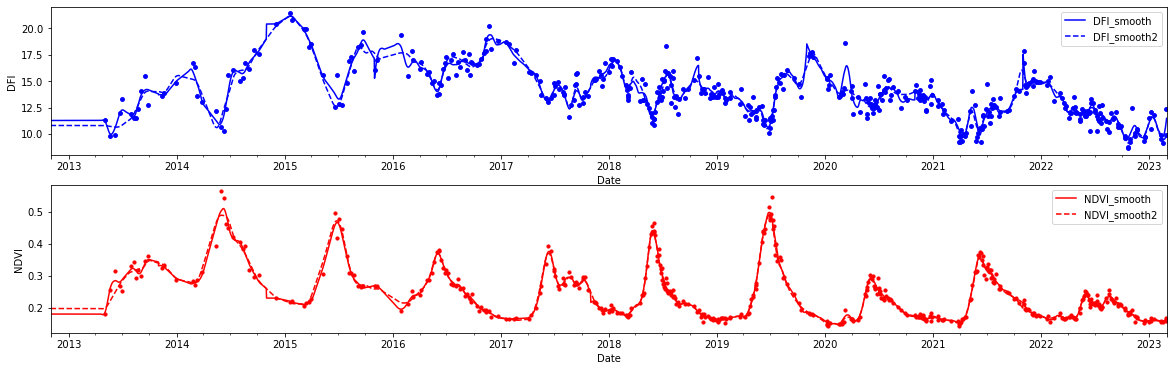

In [17]:
# plot updated smooth with start of season (blue) and peak of season (red)
plot = '10S_P1'
var1 = 'DFI'
var2 = 'NDVI'

fig, axs = plt.subplots(figsize=(20, 6), nrows=2)
df_ts[df_ts['Id'] == plot].plot.scatter(x='Date', y=var1, ax=axs[0], c='blue', s=15)
df_ts[df_ts['Id'] == plot].plot(x='Date', y= var1 + '_smooth', ax=axs[0], c='blue')
df_ts[df_ts['Id'] == plot].plot(x='Date', y= var1 + '_smooth2', ax=axs[0], c='blue', linestyle='dashed')


df_ts[df_ts['Id'] == plot].plot.scatter(x='Date', y=var2, ax=axs[1], c='red', s=10)
df_ts[df_ts['Id'] == plot].plot(x='Date', y= var2 + '_smooth', ax=axs[1], c='red')
df_ts[df_ts['Id'] == plot].plot(x='Date', y= var2 + '_smooth2', ax=axs[1], c='red', linestyle='dashed')

<AxesSubplot:xlabel='Date', ylabel='NDVI'>

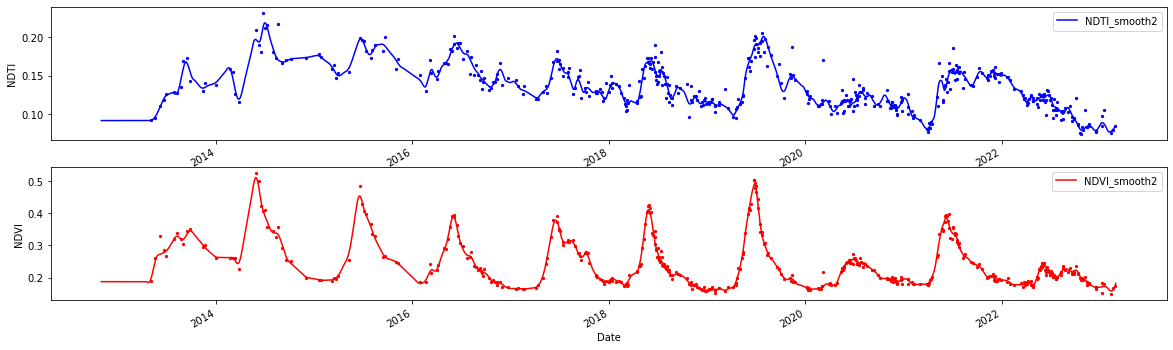

In [92]:
# plot updated smooth with start of season (blue) and peak of season (red)
plot = '15E_P3'
var1 = 'NDTI'
var2 = 'NDVI'

fig, axs = plt.subplots(figsize=(20, 6), nrows=2)
df_ts[df_ts['Id'] == plot].plot.scatter(x='Date', y=var1, ax=axs[0], c='blue', s=5)
#df_ts[df_ts['Id'] == plot].plot(x='Date', y= var1 + '_smooth', ax=axs[0], c='blue')
df_ts[df_ts['Id'] == plot].plot(x='Date', y= var1 + '_smooth2', ax=axs[0], c='blue', linestyle='solid')


df_ts[df_ts['Id'] == plot].plot.scatter(x='Date', y=var2, ax=axs[1], c='red', s=5)
#df_ts[df_ts['Id'] == plot].plot(x='Date', y= var2 + '_smooth', ax=axs[1], c='red')
df_ts[df_ts['Id'] == plot].plot(x='Date', y= var2 + '_smooth2', ax=axs[1], c='red', linestyle='solid')

<AxesSubplot:xlabel='Date', ylabel='NDVI'>

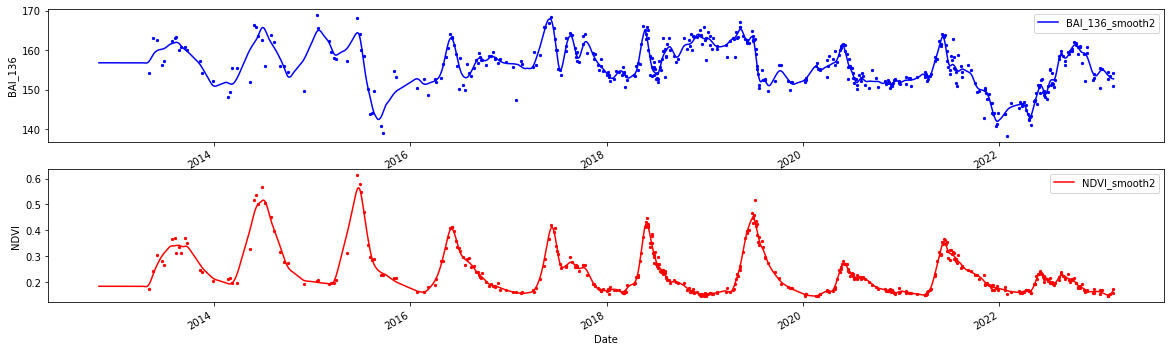

In [104]:
# plot updated smooth with start of season (blue) and peak of season (red)
plot = '10S_P3'
var1 = 'BAI_136'
var2 = 'NDVI'

fig, axs = plt.subplots(figsize=(20, 6), nrows=2)
df_ts[df_ts['Id'] == plot].plot.scatter(x='Date', y=var1, ax=axs[0], c='blue', s=5)
#df_ts[df_ts['Id'] == plot].plot(x='Date', y= var1 + '_smooth', ax=axs[0], c='blue')
df_ts[df_ts['Id'] == plot].plot(x='Date', y= var1 + '_smooth2', ax=axs[0], c='blue', linestyle='solid')


df_ts[df_ts['Id'] == plot].plot.scatter(x='Date', y=var2, ax=axs[1], c='red', s=5)
#df_ts[df_ts['Id'] == plot].plot(x='Date', y= var2 + '_smooth', ax=axs[1], c='red')
df_ts[df_ts['Id'] == plot].plot(x='Date', y= var2 + '_smooth2', ax=axs[1], c='red', linestyle='solid')

In [58]:
import re
# rename smoothed columns and drop originals
df_ts_out = df_ts.drop(columns=veg_list + band_list + ['_'.join([x, 'smooth']) for x in veg_list + band_list])
col_rename_dict = {c: re.sub('_smooth2', '', c) for c in df_ts_out.columns if '_smooth2' in c}
df_ts_out = df_ts_out.rename(columns=col_rename_dict)

In [61]:
import os
inDIR = '../data/training/'
inFILE = 'vor_2013_2022_cln_2023_08_29_plot_hls_idxs.csv'
inPATH = os.path.join(inDIR, inFILE)
df_vor = pd.read_csv(inPATH, parse_dates=[2, 3])

In [64]:
df_vor_out = pd.merge(df_vor.drop(columns=veg_list + band_list), 
                     df_ts_out[['Id', 'Date'] + veg_list + band_list], 
                     on=['Id', 'Date'],
                     how='left')

In [66]:
df_vor_out.to_csv(re.sub('.csv', '_test.csv', inPATH), index=False)